In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, classes = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [7]:
datasize = 50
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [8]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [9]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


## Split data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [11]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 200 total docs, 140 train and 60 test


### Initialize Vectorizer

In [12]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 2457


### Prepare Datatset

In [13]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [14]:
# reduce freq in doc to bin value of 1 or 0
binary = False

word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

if binary:
    wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
    wdf_test = (word_doc_frequency_norm_test > 0).astype(int)
    
else:    
    wdf_train = word_doc_frequency_norm_train.copy()
    wdf_test = word_doc_frequency_norm_test.copy()

## Word Topic Probability Distr

In [16]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
topic_doc_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_doc_count[category]
    word_topic_pr_distr[category] = pxy * (topic_doc_count[category] / word_doc_count)

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (2457, 4)


In [17]:
word_topic_pr_distr.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
000,0.0,1.0,0.0,0.0
02,1.0,0.0,0.0,0.0
034101,0.0,0.0,0.0,1.0
04110,0.0,0.0,0.0,1.0
0710,1.0,0.0,0.0,0.0


In [18]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

Topwords: Topic - sci.space


60             1.0
sky            1.0
fund           1.0
enjoy          1.0
er             1.0
equipment      1.0
reward         1.0
equip          1.0
revisionist    1.0
intestine      1.0
Name: sci.space, dtype: float64

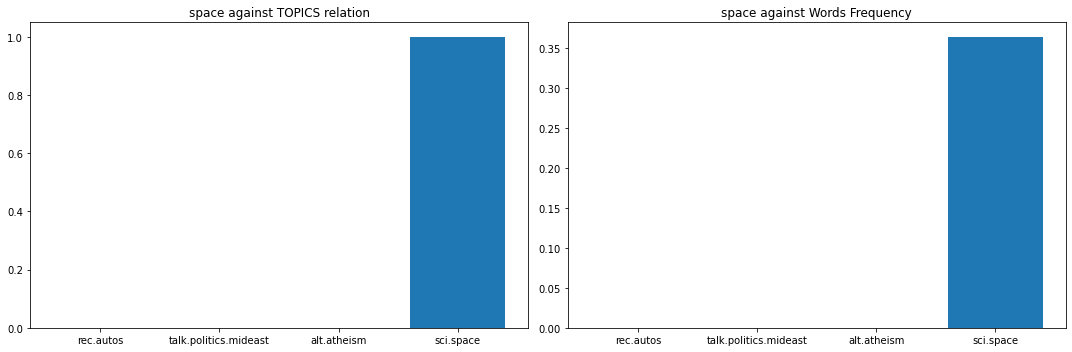

In [20]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

Document: 0, Topic: talk.politics.mideast
maybe i m a bit old fashion but have you heard about something call love it use to play some role in people s consideration for get married of course i know some people who married fictitiously in order to get a green card but make a common child for 18 000 the power of aa be limited your proposal be indeed unconventional

Inference: Document 0
actual = talk.politics.mideast, predicted = talk.politics.mideast

Topwords: Document 0
but        0.035714
get        0.035714
people     0.035714
to         0.035714
some       0.035714
in         0.035714
married    0.035714
of         0.035714
Name: 0, dtype: float64


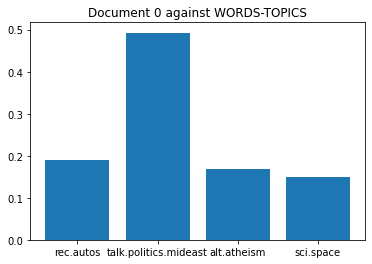

In [21]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [22]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"accuracy = {train_accuracy: .2f}%")


accuracy =  87.14%


## Topic Word Distr - Test Accuracy

In [23]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  40.00%


### Word Word Probability Distr

In [24]:
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr.loc[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (2457, 2457)


In [25]:
word_word_pr_distr.head()

,000,02,034101,04110,0710,0988,10,12,124mph,14,...,york,you,young,your,yuma,zealand,zeitgeist,zero,zillion,zone
000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.009642,0.0,0.029185,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.006749,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
04110,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0710,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.008181,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
word = "sun"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr.loc[word].sort_values(ascending=False).head(10)

Topwords: Word - sun


ran         1.0
simple      1.0
organ       1.0
slight      1.0
opposite    1.0
smell       1.0
soft        1.0
sometime    1.0
spot        1.0
fiction     1.0
Name: sun, dtype: float64

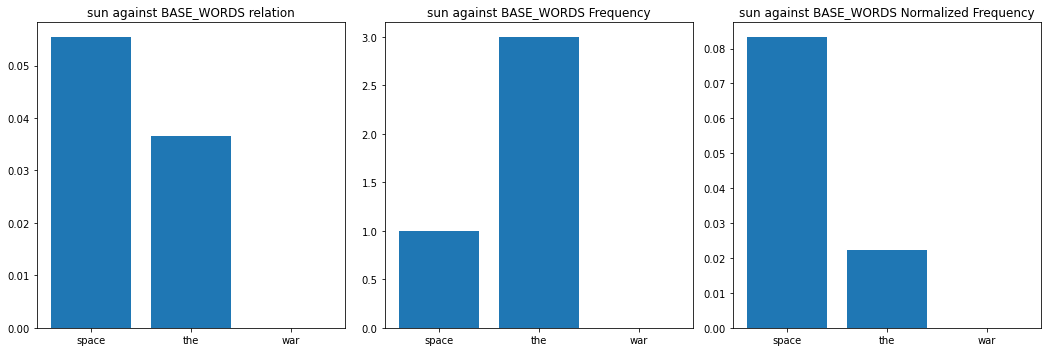

In [27]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

## Word distr 2

In [28]:
word_word_pr_distr2 = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr2.loc[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (2457, 2457)


In [ ]:
word = "sun"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr2.loc[word].sort_values(ascending=False).head(10)

In [ ]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr2.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()